In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from scipy import stats

In [ ]:
from sklearn.datasets import load_iris
 
iris = load_iris()

# 1. Defining the DBSCAN algorithm

In [ ]:
def euclidean_dist(p1, p2):
  return np.linalg.norm(np.array(p1) - np.array(p2))

There were some issues with the provided pseudocode. I did a survey over different implementations provided in the internet, namely the implementation by scikit-learn and the main paper of DBSCAN. I finally came up with the following code which I think is the best of both worlds :)

In [ ]:
def a_very_fun_dbscan(dataset, eps, n):
  # create a sequence of zeroes showing status of dataset points(classified or not): status
  status = np.zeros(len(dataset))
  # create a sequence of zeroes showing count of neighbours to a sample within range eps: neighbour_count
  neighbour_count = np.zeros(len(dataset))
  # create a sequence of nulls showing cluster label of dataset points: label
  label = np.ones(len(dataset)) * np.nan
  # create an indicator number for cluster being processed: cluster_index
  c_index = 0

  # compute distance matrix for all dataset points using euclidean distance measure
  distance_matrix = np.array([[euclidean_dist(dataset[i], dataset[j]) 
                              for j in range(len(dataset))] 
                              for i in range(len(dataset))])
  
  for i in range(len(dataset)):
    if status[i] == 0:
      # from distance matrix, find all neighbours of i within distance eps
      neigh_members = np.where(distance_matrix[i, :] <= eps)[0]
      neigh_members = np.delete(neigh_members, np.where(neigh_members == i))
      neigh_count = len(neigh_members)

      # update sequence neighbour_count for i
      neighbour_count[i] = neigh_count
      if neigh_count < n:
        # this sample is labeled -1 (noise)
        label[i] = -1
        status[i] = 1
      else:
        #  this sample is labeled with cluster_index
        label[i] = c_index
        # update current cluster
        status[i] = 1 ###################

        while len(neigh_members) != 0:
          # consider first neighbourhood_members point and call it j
          j = neigh_members[0]
          if status[j] != 1: ###############
            label[j] = c_index
            status[j] = 1
            neigh_members_j = np.where(distance_matrix[j, :] <= eps)[0]
            neigh_members_j = np.delete(neigh_members_j, np.where(neigh_members_j == j))
            neigh_count_j = len(neigh_members_j)

            # update sequence neighbour_count for i
            neighbour_count[j] = neigh_count_j
            if neigh_count_j >= n:
              # create a sequence of all unclassified neighbours of j	and add it to neighbourhood_members
              unclassified = np.where(status[neigh_members_j] == 0)
              neigh_members = np.append(neigh_members, unclassified)

              # change label of all unclassified neighbours of j and noisy neighbours of j to label of j and i
              all_the_j_friends = np.where(status[neigh_members_j] != 1)
              label[all_the_j_friends] = c_index
              status[all_the_j_friends] = 1  #############
            
          # remove first point of neighbourhood_members (j)
          neigh_members = np.delete(neigh_members, 0)
        c_index += 1

  return label

# 2. Finding the best value for eps using knee-point plot

Let's first find the optimal value for k (I used [this](https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/) link):


The logical method is to split the data to train and test and try to find the best k based on the performance of the model. As the data is very small and doesn't bias us very much in this section, I just went on with the whole data:

In [ ]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(iris.data, iris.target)
    # Let's just find the error on the main dataset as we don't have much data to split
    pred_i = knn.predict(iris.data)
    error.append(np.mean(pred_i != iris.target))

Text(0, 0.5, 'Mean Error')

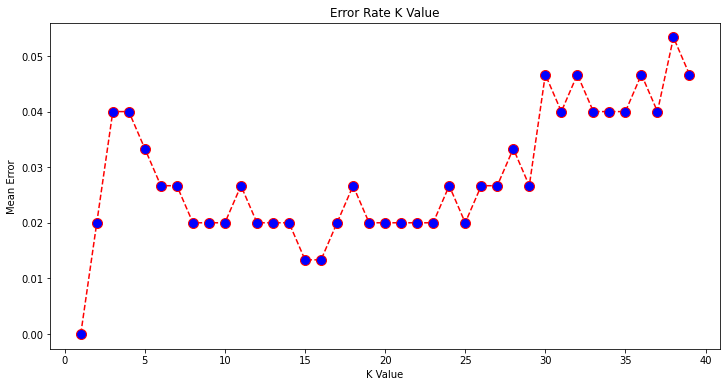

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

The minimum error is for k=0 which is 0! So let's try to forget about that and find the min in the others:

In [ ]:
np.argmin(np.array(error[1:]))

13

I used [this link](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) for this section:

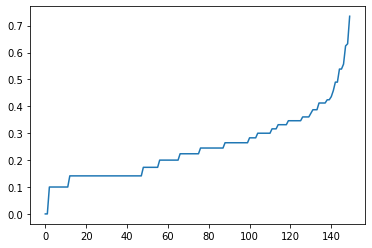

In [ ]:
neigh = KNeighborsClassifier(13)
nbrs = neigh.fit(iris.data, iris.target)
distances, indices = nbrs.kneighbors(iris.data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

It seems that a value of 0.4 is a good value for eps.

# 3. Finding the value of n

There a lot of discussion on the web on how to find the value of n. [Some](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd) suggest static ways like n = 2*dim.

In the field of ML, as n is a hyperparameter, the main way is to split the data into train, valid, test and babysit a model with different parameters searching for the best configuration. However, in this simple question I'm not going to make things overcomplicated as the point of the exercise is the DBSCAN algorithm itself. I'll stick with a very simple approach.

The definition of *Good* has been under a lot of attention throughout the history of philosophy. Mostly it is the *Problem of evil* which has had a lot of impact on civilizations and nation's onthologies. As well, in the field of ML, the definition of a *Good* model differs from task to task, from designer to designer. Altough there has been many attempts to quantify this definition, it still remains an open field of research.

For the task of clustering which is mostly considered an unsupervised task, there are many metrics proposed and [implemented](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). 

Here we still wanna keep things simple. I manually used different values for starting from 1 to 15 for the n and watched the resutls. It seemed that if We have very small n, the number of clusters will be very large and it we have a large n the number of noises will be very large. It seemed that using the value of 5 is a just an enough guess:

In [ ]:
y_pred = a_very_fun_dbscan(iris.data, eps=0.4, n=5)
y_pred

array([ 0., 14., 13., 16., 13., 13., 14.,  7.,  7.,  7.,  2.,  2.,  2.,
        2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.,  2.,
        0.,  0.,  0.,  2.,  2.,  0., -1., -1.,  2.,  0.,  3.,  0.,  4.,
        0.,  0., -1.,  4.,  1., -1.,  2.,  0.,  4.,  0.,  0., -1.,  5.,
       -1., -1.,  6.,  7.,  5., -1.,  6., -1., -1.,  8., -1., -1., -1.,
        5.,  7.,  9., -1.,  9., -1.,  8., -1., -1.,  6.,  5.,  6., -1.,
        7., -1., -1., -1.,  9., -1., -1., -1.,  5., -1.,  8., 10.,  7.,
        5.,  9., -1.,  7.,  7.,  7.,  8., -1.,  8., -1., 11., -1., -1.,
       12., -1., -1., -1., -1., -1., -1., 13., 14., 11., -1., 15., 13.,
       -1., -1., -1., 14., 11., -1., 16., 12., -1., 16., 16., 12., -1.,
       -1., -1., 12., 16., -1., -1., 15., -1., -1., 14., 12., -1., 11.,
       12., -1., 14., 13., 13., 15., 11.])

# 4. Evaluating

In [ ]:
y_pred_new = y_pred.copy()

In [ ]:
y_pred_new[:] = 0

In [ ]:
for i in range(3):
  mask = np.where(iris.target == i)
  label = int(stats.mode(y_pred[mask])[0][0])
  mask = np.where(y_pred[i*50:(i+1)*50]==label)
  y_pred_new[i*50:(i+1)*50][mask] = i

In [ ]:
y_pred_new

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0.,
       2., 2., 0., 2., 2., 2., 2., 2., 2., 0., 0., 0., 2., 0., 0., 2., 2.,
       2., 0., 0., 2., 0., 0., 2., 0., 0., 0., 2., 2., 2., 0., 0., 2., 2.,
       0., 2., 2., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0.])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [ ]:
print(classification_report(iris.target, y_pred_new))

              precision    recall  f1-score   support

           0       0.49      1.00      0.65        50
           1       1.00      0.46      0.63        50
           2       1.00      0.48      0.65        50

    accuracy                           0.65       150
   macro avg       0.83      0.65      0.64       150
weighted avg       0.83      0.65      0.64       150



In [ ]:
cohen_kappa_score(iris.target, y_pred_new)

0.4700000000000001